# MLP

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class MLPRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list[int], dropout: float, output_size: int = 1):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Accept (B, L, F) or (B, L*F)
        if x.dim() == 3:
            b, l, f = x.shape
            x = x.view(b, l * f)
        out = self.net(x)
        return out.squeeze(-1)


In [303]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# ----- Utility: Dynamically reconstruct MLP from a saved state_dict -----
class DynamicMLP(nn.Module):
    def __init__(self, layer_dims: list[int]):
        super().__init__()
        layers = []
        for i in range(len(layer_dims) - 1):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            layers.append(nn.Linear(in_dim, out_dim))
            if i < len(layer_dims) - 2:
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def build_mlp_from_state_dict(state_dict: dict) -> DynamicMLP:
    """Infer MLP layer sizes from Linear weights in state_dict and construct the model."""
    linear_weights = [(k, v.shape) for k, v in state_dict.items() if k.endswith('.weight')]
    # Sort by module order if present (e.g., 'net.0.weight', 'net.3.weight', ...)
    def sort_key(item):
        k = item[0]
        parts = k.split('.')
        idxs = [int(p) for p in parts if p.isdigit()]
        return idxs[0] if idxs else 0
    linear_weights.sort(key=sort_key)
    layer_dims = []
    for _, shape in linear_weights:
        out_dim, in_dim = shape
        if not layer_dims:
            layer_dims = [in_dim, out_dim]
        else:
            layer_dims.append(out_dim)
    return DynamicMLP(layer_dims)

# ----- Loader: load model from ./models/best_10.pth -----
def load_saved_mlp(model_path: str, device: torch.device = None) -> nn.Module:
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ckpt = torch.load(model_path, map_location=device)
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    elif isinstance(ckpt, dict):
        state_dict = ckpt
    else:
        raise ValueError('Unexpected checkpoint format. Expected a state_dict or dict with state_dict key.')
    model = build_mlp_from_state_dict(state_dict).to(device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

# ----- Feature order: read from processed_data_10.pkl produced in project_data_process -----
def get_feature_order_from_processed(N: int = 10) -> list[str]:
    pkl_path = f'processed_data_{N}.pkl'
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    # feature_trained_name contains base names (e.g., 'Bitcoin', 'Apple', ...)
    feature_names = data.get('feature_trained_name')
    if feature_names is None:
        raise ValueError('feature_trained_name not found in processed data.')
    # Convert to log-return column names
    feature_cols = [f'{name}_LogReturn' for name in feature_names]
    return feature_cols

# ----- Load precomputed unshuffled windows from .pth -----
def load_unshuffled_windows(N: int = 10, device: torch.device = None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    path = f'processed_data_{N}_unshuffle.pth'
    if not os.path.exists(path):
        raise FileNotFoundError(f"Expected {path} not found. Generate via project_data_process.ipynb Cell 17.")
    blob = torch.load(path, map_location=device)
    X_train_unshuffle = blob['X_train']  # shape: (num_sequences, window_size, num_features)
    y_train_unshuffle = blob['y_train']  # shape: (num_sequences, window_size, num_features)
    return X_train_unshuffle.to(device), y_train_unshuffle.to(device)

# ----- Apply predicted log-return to S&P500 raw prices from the 10th data point -----

def apply_log_returns_to_price(prices: np.ndarray, start_index: int, pred_log_returns: np.ndarray) -> np.ndarray:
    """
    Given raw prices and predicted log-returns sequence, apply cumulatively
    starting from start_index (e.g., 9 for 10th data point).
    prices: array of raw S&P500 prices
    pred_log_returns: array of log-return predictions aligned with subsequent steps
    Returns an array of reconstructed prices of length len(pred_log_returns)+1 starting at prices[start_index].
    """
    out = [prices[start_index]]
    for r in pred_log_returns:
        next_price = out[-1] * (np.exp(float(r)))
        print(np.exp(float(r)))
        print("gan")
        out.append(next_price)
    return np.array(out)

def apply_log_returns_to_price_gan(prices: np.ndarray, start_index: int, pred_log_returns: np.ndarray) -> np.ndarray:
    """
    Given raw prices and predicted log-returns sequence, apply cumulatively
    starting from start_index (e.g., 9 for 10th data point).
    prices: array of raw S&P500 prices
    pred_log_returns: array of log-return predictions aligned with subsequent steps
    Returns an array of reconstructed prices of length len(pred_log_returns)+1 starting at prices[start_index].
    """
    out = [prices[start_index]]
    for r in pred_log_returns:
        next_price = out[-1] * (np.exp(float(r)))
        print(np.exp(float(r)))
        out.append(next_price)
    return np.array(out)

def reconstruct_using_real_prices(prices, start_index, pred_log_returns):
    """
    prices: raw S&P500 prices
    start_index: where your model starts predicting (N-1)
    pred_log_returns: model predictions aligned with windows
    """
    out = []

    for i, r in enumerate(pred_log_returns):
        real_price = prices[start_index + i]
        predicted_price = real_price * np.exp(float(r))
        out.append(predicted_price)

    return np.array(out)


def apply_log_returns_to_price_time_series(prices: np.ndarray, start_index: int, pred_log_returns: np.ndarray) -> np.ndarray:
    """
    Given raw prices and predicted log-returns sequence, apply cumulatively
    starting from start_index (e.g., 9 for 10th data point).
    prices: array of raw S&P500 prices
    pred_log_returns: array of log-return predictions aligned with subsequent steps
    Returns an array of reconstructed prices of length len(pred_log_returns)+1 starting at prices[start_index].
    """
    out = [prices[start_index]]
    for r in pred_log_returns:
        next_price = out[-1] * (np.exp(float(r+0.00045595086117771453)))
        # print(np.exp(float(r)))
        out.append(next_price)
    return np.array(out)

print("Functions ready: load_saved_mlp, get_feature_order_from_processed, load_unshuffled_windows, apply_log_returns_to_price")


Functions ready: load_saved_mlp, get_feature_order_from_processed, load_unshuffled_windows, apply_log_returns_to_price


In [205]:
# Runner: Load unshuffled windows, normalize, and run MLP predictions
import numpy as np
import pandas as pd
import torch
import re

# Config
N = 10
model_path = './models/best_mlp_10.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load unshuffled training windows
X_train_unshuffle = load_unshuffled_windows(N=N, device=device)  # (B, L, F)
B, L, F = X_train_unshuffle.shape
input_dim = L * F

# Per-feature normalization using training statistics (mean/std over all sequences and timesteps)
feat_mean = X_train_unshuffle.mean(dim=(0, 1), keepdim=True)  # (1,1,F)
feat_std = X_train_unshuffle.std(dim=(0, 1), keepdim=True)    # (1,1,F)
# Avoid division by zero
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)
X_norm = (X_train_unshuffle - feat_mean) / feat_std  # (B,L,F)

# Reconstruct original MLPRegressor architecture
hidden_dims = [256, 128, 64]
dropout = 0.2
mlp = MLPRegressor(input_dim=input_dim, hidden_dims=hidden_dims, dropout=dropout, output_size=1).to(device)

# Load checkpoint weights with non-strict to handle non-param layers positions
ckpt = torch.load(model_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt
missing, unexpected = mlp.load_state_dict(state_dict, strict=False)
mlp.eval()

# Flatten normalized sequences to match MLP input (B, N*F)
X_flat = X_norm.reshape(B, input_dim)

# Predict log-returns for each sequence
with torch.no_grad():
    preds = mlp(X_flat).cpu().numpy()  # shape: (B,)

# Load raw S&P500 prices from data.csv
raw_df = pd.read_csv('data.csv')

raw_df = raw_df.iloc[::-1].reset_index(drop=True)


# Try to identify the S&P500 column robustly
candidates = [
    r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$",
    r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"
]
price_col = None
for pat in candidates:
    matches = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if matches:
        price_col = matches[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    heuristics = ["sp", "s&p", "sandp", "standard & poor"]
    for h in heuristics:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError("Could not locate S&P500 price column in data.csv.")

sp500_prices = raw_df[price_col].values

# Reconstruct trajectory from the 10th data point (index 9)
recon_prices = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds)

print({
    'num_sequences': int(B),
    'input_shape': (int(B), int(L), int(F)),
    'flat_shape': (int(B), int(input_dim)),
    'missing_keys': missing,
    'unexpected_keys': unexpected,
    'price_col': str(price_col),
    'first_pred': float(preds[0]) if len(preds) else None,
    'start_price': float(sp500_prices[N-1]),
    'recon_len': len(recon_prices)
})


tensor([[[ 0.7512,  0.5448,  0.0407,  ...,  0.2123, -0.5368, -0.5979],
         [ 1.0029,  0.3257,  0.0059,  ...,  0.0397,  0.0604,  0.6398],
         [-0.1946,  0.7386,  0.2568,  ...,  0.4515,  0.2857,  0.0595],
         ...,
         [ 2.1558,  0.4439,  0.0045,  ..., -0.5988, -0.6134, -0.5704],
         [-0.0478, -0.8848, -0.8156,  ...,  0.5353, -0.2683, -0.2195],
         [-0.2776, -0.3040, -0.5548,  ..., -0.1333,  0.3350,  0.3564]],

        [[ 1.0029,  0.3257,  0.0059,  ...,  0.0397,  0.0604,  0.6398],
         [-0.1946,  0.7386,  0.2568,  ...,  0.4515,  0.2857,  0.0595],
         [-0.3250,  0.9544, -0.2913,  ..., -0.5238, -0.0098, -0.3955],
         ...,
         [-0.0478, -0.8848, -0.8156,  ...,  0.5353, -0.2683, -0.2195],
         [-0.2776, -0.3040, -0.5548,  ..., -0.1333,  0.3350,  0.3564],
         [ 0.4565, -0.2166, -0.9424,  ...,  0.2788, -0.0212, -0.3615]],

        [[-0.1946,  0.7386,  0.2568,  ...,  0.4515,  0.2857,  0.0595],
         [-0.3250,  0.9544, -0.2913,  ..., -0

# Transformer

In [177]:

# ---------- Positional Encoding ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, L, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# ---------- Time Series Transformer ----------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size: int, d_model: int, n_heads: int,
                 num_encoder_layers: int, dim_feedforward: int, dropout: float,
                 output_size: int = 1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_size)
        )

    def forward(self, x):
        # x: (B, L, input_size)
        x = self.input_proj(x)           # (B, L, d_model)
        x = self.pos_enc(x)              # add positional encoding
        y = self.encoder(x)              # (B, L, d_model)
        last = y[:, -1, :]               # use last time step
        out = self.head(last)            # (B, output_size)
        return out.squeeze(-1)


In [178]:
# Compare MLP vs Transformer prediction magnitudes
print("=== MLP PREDICTIONS (first 10) ===")
print(preds[:10])
print(f"\nMLP Stats: mean={preds.mean():.6e}, std={preds.std():.6e}")
print(f"MLP Range: [{preds.min():.6e}, {preds.max():.6e}]")

print("\n=== COMPARISON ===")
print(f"MLP std / Transformer std: {preds.std() / 2.844174e-03:.2f}x")
print(f"MLP mean magnitude: {np.abs(preds).mean():.6e}")
print(f"Transformer mean magnitude: {2.844174e-03:.6e}")


=== MLP PREDICTIONS (first 10) ===
[-0.00087934  0.00167969  0.00218211 -0.00116536 -0.0002763  -0.00923789
  0.00106278 -0.00091643 -0.00084221 -0.00408364]

MLP Stats: mean=1.659647e-03, std=1.257482e-02
MLP Range: [-1.679138e-01, 8.619836e-02]

=== COMPARISON ===
MLP std / Transformer std: 4.42x
MLP mean magnitude: 6.267162e-03
Transformer mean magnitude: 2.844174e-03


In [179]:
# Runner: Transformer predictions on normalized X_train_unshuffle (exact arch)
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re

N = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_path = './models/best_transformer_10.pth'

# Define architecture exactly as in training
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size: int, d_model: int, n_heads: int,
                 num_encoder_layers: int, dim_feedforward: int, dropout: float,
                 output_size: int = 1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_size)
        )
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        y = self.encoder(x)
        last = y[:, -1, :]
        out = self.head(last)
        return out.squeeze(-1)

# Load unshuffled and normalize (recompute to ensure consistency)
X_train_unshuffle = load_unshuffled_windows(N=N, device=device)
B, L, F = X_train_unshuffle.shape
feat_mean = X_train_unshuffle.mean(dim=(0,1), keepdim=True)
feat_std  = X_train_unshuffle.std(dim=(0,1), keepdim=True)
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)
X_norm = (X_train_unshuffle - feat_mean) / feat_std

# Instantiate transformer to match training hyperparameters
d_model = 64
n_heads = 4
num_layers = 3
dim_feedforward = 128
dropout = 0.2
transformer = TimeSeriesTransformer(input_size=F, d_model=d_model, n_heads=n_heads,
                                    num_encoder_layers=num_layers, dim_feedforward=dim_feedforward,
                                    dropout=dropout, output_size=1).to(device)

# Load checkpoint from training with STRICT=True to catch mismatches
ckpt = torch.load(transformer_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt

# Print diagnostic info before loading
print(f"Checkpoint keys sample: {list(state_dict.keys())[:5]}")
print(f"Model expects input_size={F}, loading from {transformer_path}")

missing, unexpected = transformer.load_state_dict(state_dict, strict=True)
print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")
transformer.eval()

with torch.no_grad():
    preds_tf = transformer(X_norm).cpu().numpy()

print(f"Predictions stats: mean={preds_tf.mean():.6e}, std={preds_tf.std():.6e}, min={preds_tf.min():.6e}, max={preds_tf.max():.6e}")

# Load S&P column
raw_df = pd.read_csv('data.csv')
raw_df = raw_df.iloc[::-1].reset_index(drop=True)

candidates = [r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$", r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"]
price_col = None
for pat in candidates:
    m = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if m:
        price_col = m[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    for h in ["sp", "s&p", "sandp", "standard & poor"]:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError('Could not locate S&P500 price column in data.csv.')

sp500_prices = raw_df[price_col].values
recon_prices_tf = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_tf)

print({
    'transformer_preds_len': len(preds_tf),
    'start_price': float(sp500_prices[N-1]),
    'recon_len_tf': len(recon_prices_tf),
    'price_col': str(price_col)
})


Checkpoint keys sample: ['input_proj.weight', 'input_proj.bias', 'pos_enc.pe', 'encoder.layers.0.self_attn.in_proj_weight', 'encoder.layers.0.self_attn.in_proj_bias']
Model expects input_size=10, loading from ./models/best_transformer_10.pth
Missing keys: []
Unexpected keys: []
Predictions stats: mean=-7.076168e-05, std=2.844174e-03, min=-1.465640e-03, max=6.638816e-02
{'transformer_preds_len': 563, 'start_price': 3289.29, 'recon_len_tf': 564, 'price_col': 'S&P_500'}


In [180]:
# DIAGNOSTIC: Check if we're using the right normalization stats from training
import pickle

# Load the normalization stats that were computed during training
with open(f'processed_data_{N}.pkl', 'rb') as f:
    train_data = pickle.load(f)
    X_train_original = train_data['X_train']
    
# Compute stats from the original training data
train_mean_original = X_train_original.mean(axis=(0, 1), keepdims=True)
train_std_original = X_train_original.std(axis=(0, 1), keepdims=True)

# Compare with what we computed from unshuffled
print("=== NORMALIZATION COMPARISON ===")
print(f"Mean from original X_train: {train_mean_original.ravel()[:3]}...")
print(f"Mean from X_train_unshuffle: {feat_mean.cpu().numpy().ravel()[:3]}...")
print(f"Std from original X_train: {train_std_original.ravel()[:3]}...")
print(f"Std from X_train_unshuffle: {feat_std.cpu().numpy().ravel()[:3]}...")
print(f"Mean difference: {np.abs(train_mean_original - feat_mean.cpu().numpy()).max():.2e}")
print(f"Std difference: {np.abs(train_std_original - feat_std.cpu().numpy()).max():.2e}")

# Check a few raw predictions before reconstruction
print("\n=== RAW TRANSFORMER PREDICTIONS (first 10) ===")
print(preds_tf[:10])
print(f"\nStats: mean={preds_tf.mean():.6e}, std={preds_tf.std():.6e}")
print(f"Range: [{preds_tf.min():.6e}, {preds_tf.max():.6e}]")

# Check if model is actually in eval mode
print(f"\nModel in eval mode: {not transformer.training}")
print(f"Dropout layers active: {any(m.training for m in transformer.modules() if isinstance(m, nn.Dropout))}")


=== NORMALIZATION COMPARISON ===
Mean from original X_train: [0.00538983 0.00411607 0.00210544]...
Mean from X_train_unshuffle: [0.00538983 0.00411607 0.00210544]...
Std from original X_train: [0.06493099 0.04605467 0.04072821]...
Std from X_train_unshuffle: [0.06493676 0.04605876 0.04073183]...
Mean difference: 4.29e-10
Std difference: 5.77e-06

=== RAW TRANSFORMER PREDICTIONS (first 10) ===
[-1.78888789e-04 -2.37714150e-04 -2.18566624e-04  5.80720371e-05
  1.53014087e-04 -3.34285432e-05 -5.43702627e-04 -5.06118755e-04
 -1.14953145e-05 -1.60479103e-04]

Stats: mean=-7.076168e-05, std=2.844174e-03
Range: [-1.465640e-03, 6.638816e-02]

Model in eval mode: True
Dropout layers active: False


# LSTM

In [181]:
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(ImprovedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Add dropout after LSTM
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
# Reduced model complexity
# output_size = 1
# input_size = 10

# hidden_size_new = 32  # Reduced from 64
# num_layers_new = 1    # Reduced from 2
# learning_rate_new = 0.001
# num_epochs_new = 20  # More epochs but with early stopping

# # Initialize improved model
# model_improved = ImprovedLSTM(input_size, hidden_size_new, num_layers_new, output_size).to(device)

In [182]:
# Runner: LSTM predictions on normalized X_train_unshuffle
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re

N = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_path = './models/improved_lstm_10.pth'

# Load unshuffled and normalize (recompute to ensure consistency)
X_train_unshuffle = load_unshuffled_windows(N=N, device=device)
B, L, F = X_train_unshuffle.shape
feat_mean = X_train_unshuffle.mean(dim=(0,1), keepdim=True)
feat_std  = X_train_unshuffle.std(dim=(0,1), keepdim=True)
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)
X_norm = (X_train_unshuffle - feat_mean) / feat_std

# Instantiate LSTM to match training hyperparameters
input_size = F
hidden_size = 32
num_layers_lstm = 1
output_size = 1
dropout_lstm = 0.3

lstm_model = ImprovedLSTM(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=num_layers_lstm, output_size=output_size, 
                          dropout=dropout_lstm).to(device)

# Load checkpoint from training with STRICT=True to catch mismatches
ckpt = torch.load(lstm_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt

# Print diagnostic info before loading
print(f"Checkpoint keys sample: {list(state_dict.keys())[:5]}")
print(f"Model expects input_size={input_size}, loading from {lstm_path}")

missing, unexpected = lstm_model.load_state_dict(state_dict, strict=True)
print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")
lstm_model.eval()

with torch.no_grad():
    preds_lstm = lstm_model(X_norm).cpu().numpy()

print(f"Predictions stats: mean={preds_lstm.mean():.6e}, std={preds_lstm.std():.6e}, min={preds_lstm.min():.6e}, max={preds_lstm.max():.6e}")

# Load S&P column
raw_df = pd.read_csv('data.csv')
raw_df = raw_df.iloc[::-1].reset_index(drop=True)

candidates = [r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$", r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"]
price_col = None
for pat in candidates:
    m = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if m:
        price_col = m[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    for h in ["sp", "s&p", "sandp", "standard & poor"]:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError('Could not locate S&P500 price column in data.csv.')

sp500_prices = raw_df[price_col].values
recon_prices_lstm = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_lstm)

print({
    'lstm_preds_len': len(preds_lstm),
    'start_price': float(sp500_prices[N-1]),
    'recon_len_lstm': len(recon_prices_lstm),
    'price_col': str(price_col)
})


Checkpoint keys sample: ['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'fc1.weight']
Model expects input_size=10, loading from ./models/improved_lstm_10.pth
Missing keys: []
Unexpected keys: []
Predictions stats: mean=-3.481488e-04, std=4.902492e-03, min=-8.367065e-02, max=4.202411e-02
{'lstm_preds_len': 563, 'start_price': 3289.29, 'recon_len_lstm': 564, 'price_col': 'S&P_500'}


/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_28816/1197941199.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price = out[-1] * np.exp(float(r))


In [183]:
# 

# TCN

In [184]:
# ---------- TCN building blocks ----------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        # x shape: (B, C, L + pad)
        if self.chomp_size == 0:
            return x
        return x[:, :, : -self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(out_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

        # Init
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, tcn_channels, kernel_size=3, dropout=0.2, output_size=1):
        super().__init__()
        layers = []
        num_levels = len(tcn_channels)
        in_ch = input_size
        for i in range(num_levels):
            out_ch = tcn_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                                        dilation=dilation_size, padding=padding, dropout=dropout))
            in_ch = out_ch
        self.tcn = nn.Sequential(*layers)

        # final head: takes last time-step's features (we'll index last element)
        self.linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(tcn_channels[-1], tcn_channels[-1] // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(tcn_channels[-1] // 2, output_size)
        )

    def forward(self, x):
        # x: (B, seq_len, features)
        # convert to (B, C, L) for Conv1d where C=input_size, L=seq_len
        x = x.permute(0, 2, 1).contiguous()  # (B, features, seq_len)
        y = self.tcn(x)                       # (B, channels, seq_len)
        # take the last time-step features (causal conv => last index is final)
        last = y[:, :, -1]                    # (B, channels)
        out = self.linear(last)               # (B, output_size)
        return out.squeeze(-1)

In [231]:
# Runner: TCN predictions on normalized X_train_unshuffle
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re

N = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tcn_path = './models/best_tcn_10_1.pth'  # FIXED: was missing ./models/ prefix

# Load unshuffled and normalize (recompute to ensure consistency)
X_train_unshuffle, y_train_unshuffle = load_unshuffled_windows(N=N, device=device)
B, L, F = X_train_unshuffle.shape
feat_mean = X_train_unshuffle.mean(dim=(0,1), keepdim=True)
feat_std  = X_train_unshuffle.std(dim=(0,1), keepdim=True)
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)

X_norm = (X_train_unshuffle - feat_mean) / feat_std
# print(X_norm)
# X_norm = torch.zeros_like(X_train_unshuffle)

# Instantiate TCN to match training hyperparameters
input_size_tcn = F
tcn_channels = [32, 32, 32]
kernel_size = 3
dropout_tcn = 0.3  # MUST match training (was 0.3, not 0.2!)
output_size = 1

tcn_model = TCN(input_size=input_size_tcn, tcn_channels=tcn_channels, 
                kernel_size=kernel_size, dropout=dropout_tcn, 
                output_size=output_size).to(device)

# Load checkpoint from training with STRICT=True to catch mismatches
ckpt = torch.load(tcn_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt

# Print diagnostic info before loading
print(f"Checkpoint keys sample: {list(state_dict.keys())[:5]}")
print(f"Model expects input_size={input_size_tcn}, loading from {tcn_path}")

missing, unexpected = tcn_model.load_state_dict(state_dict, strict=True)
print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")
tcn_model.eval()

# Verify model is in eval mode and check input statistics
print(f"\nModel in training mode: {tcn_model.training}")
print(f"Input shape: {X_norm.shape}")
print(f"Input stats: mean={X_norm.mean().item():.6f}, std={X_norm.std().item():.6f}")
print(f"Input min={X_norm.min().item():.6f}, max={X_norm.max().item():.6f}")
print(f"Sample inputs from first window: {X_norm[0, :3, 0].cpu().numpy()}")

# Direct prediction on all windows (no autoregressive rollout)
# Each window predicts one step ahead, matching training setup
with torch.no_grad():
    preds_tcn = tcn_model(X_norm).cpu().numpy()  # shape: (B,)
    
# print(preds_tcn)

print(f"Predictions stats: mean={preds_tcn.mean():.6e}, std={preds_tcn.std():.6e}, min={preds_tcn.min():.6e}, max={preds_tcn.max():.6e}")

# Load S&P column
raw_df = pd.read_csv('data.csv')
raw_df = raw_df.iloc[::-1].reset_index(drop=True)

candidates = [r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$", r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"]
price_col = None
for pat in candidates:
    m = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if m:
        price_col = m[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    for h in ["sp", "s&p", "sandp", "standard & poor"]:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError('Could not locate S&P500 price column in data.csv.')

sp500_prices = raw_df[price_col].values
recon_prices_tcn = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_tcn)


print({
    'tcn_preds_len': len(preds_tcn),
    'start_price': float(sp500_prices[N-1]),
    'recon_len_tcn': len(recon_prices_tcn),
    'price_col': str(price_col)
})


/opt/miniconda3/envs/dsml/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Checkpoint keys sample: ['tcn.0.conv1.bias', 'tcn.0.conv1.weight_g', 'tcn.0.conv1.weight_v', 'tcn.0.conv2.bias', 'tcn.0.conv2.weight_g']
Model expects input_size=10, loading from ./models/best_tcn_10_1.pth
Missing keys: []
Unexpected keys: []

Model in training mode: False
Input shape: torch.Size([563, 10, 10])
Input stats: mean=0.000000, std=0.999920
Input min=-14.104436, max=8.363824
Sample inputs from first window: [ 0.75120527  1.0029169  -0.19456185]
Predictions stats: mean=-1.026819e-01, std=9.106262e-02, min=-5.194631e-01, max=9.189091e-01
{'tcn_preds_len': 563, 'start_price': 3289.29, 'recon_len_tcn': 564, 'price_col': 'S&P_500'}


In [232]:
# Test single sample prediction
print("Input shape:", X_norm[0].shape)
print("Input device:", X_norm[0].device)

# Add batch dimension and ensure model is in eval mode
tcn_model.eval()
with torch.no_grad():
    single_input = X_norm[0].unsqueeze(0)  # Add batch dimension: (1, 10, 10)
    print("Input with batch dim:", single_input.shape)
    prediction = tcn_model(single_input).cpu().numpy()
    print("Prediction:", prediction)
    print("Prediction type:", type(prediction))

Input shape: torch.Size([10, 10])
Input device: cpu
Input with batch dim: torch.Size([1, 10, 10])
Prediction: [-0.13914558]
Prediction type: <class 'numpy.ndarray'>


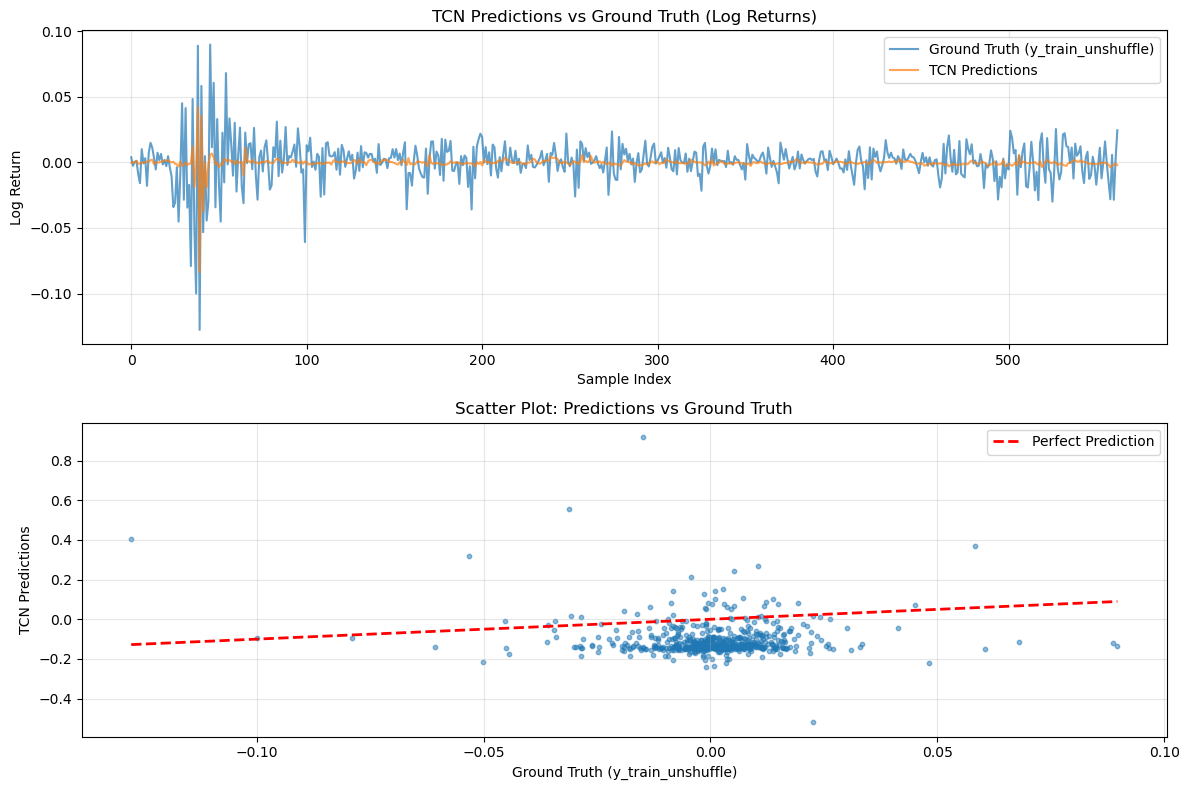


=== TCN Performance Metrics ===
MSE: 1.950157e-02
MAE: 1.229495e-01
R² Score: -71.527580
Correlation: -0.101418


In [298]:
# Plot y_train_unshuffle vs TCN predictions
import matplotlib.pyplot as plt

y_train_np = y_train_unshuffle.cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Direct comparison
axes[0].plot(y_train_np, label='Ground Truth (y_train_unshuffle)', alpha=0.7, linewidth=1.5)
axes[0].plot(preds_lstm, label='TCN Predictions', alpha=0.7, linewidth=1.5)
axes[0].set_title('TCN Predictions vs Ground Truth (Log Returns)')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Log Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot to see correlation
axes[1].scatter(y_train_np, preds_tcn, alpha=0.5, s=10)
axes[1].plot([y_train_np.min(), y_train_np.max()], 
             [y_train_np.min(), y_train_np.max()], 
             'r--', label='Perfect Prediction', linewidth=2)
axes[1].set_title('Scatter Plot: Predictions vs Ground Truth')
axes[1].set_xlabel('Ground Truth (y_train_unshuffle)')
axes[1].set_ylabel('TCN Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation and error metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_train_np, preds_tcn)
mae = mean_absolute_error(y_train_np, preds_tcn)
r2 = r2_score(y_train_np, preds_tcn)
corr = np.corrcoef(y_train_np, preds_tcn)[0, 1]

print(f"\n=== TCN Performance Metrics ===")
print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R² Score: {r2:.6f}")
print(f"Correlation: {corr:.6f}")

In [304]:
preds_corrected = preds_tcn - preds_tcn.mean()
recon_prices_tcn = apply_log_returns_to_price_time_series(sp500_prices, start_index=N-1, pred_log_returns=preds_corrected)

recon_prices_lstm = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_lstm)

# print(recon_prices_tcn)

0.9996539394458512
gan
0.9998917414737233
gan
1.0001152950674772
gan
1.001131785269689
gan
0.9988233860010551
gan
0.9991924728101087
gan
0.9998461033372708
gan
0.9995377797042391
gan
0.999929417553128
gan
1.0006945103751326
gan
1.0004443926666555
gan
1.0016037126078041
gan
1.0020220476547494
gan
0.9985166950052383
gan
0.9997114638842287
gan
1.000093468176176
gan
0.9998076994491409
gan
1.0005366416229546
gan
1.0007431212151103
gan
1.0013502267149694
gan
1.0010764297347488
gan
1.001722739557612
gan
1.0006808011993442
gan
0.9998996755145196
gan
1.0004406433662163
gan
0.9989346510401337
gan
0.998419951405857
gan
0.996703859609862
gan
1.0004910010728898
gan
0.997443730644913
gan
0.9978632774446642
gan
0.9997942035466187
gan
0.9981880344422843
gan
0.9988073685547784
gan
0.998932420110347
gan
1.0121076678536043
gan
0.9815114261447353
gan
0.9972809947007564
gan
1.0429196188462302
gan
0.9197341243736796
gan
1.0363144214303146
gan
0.9632088911076503
gan
1.0000183975153711
gan
0.9812508954547777


/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_28816/3698428080.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price = out[-1] * (np.exp(float(r)))
/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_28816/3698428080.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(np.exp(float(r)))


In [288]:
# start_idx = N - 1
# end_idx = start_idx + len(recon_prices) - 2

# # Align ground truth slice
# gt_slice = sp500_prices[start_idx:end_idx+1]
# print(len(gt_slice))
# print(len(preds_tcn))

# # Since gt_slice is already sliced, start_index should be 0, not N-1
# recon_prices_tcn = reconstruct_using_real_prices(gt_slice, 0, preds_tcn)
# recon_prices_lstm = reconstruct_using_real_prices(gt_slice, 0, preds_lstm)
# recon_prices_tf = reconstruct_using_real_prices(gt_slice, 0, preds_tf)
# recon_prices_mlp = reconstruct_using_real_prices(gt_slice, 0, preds)

# PLOT

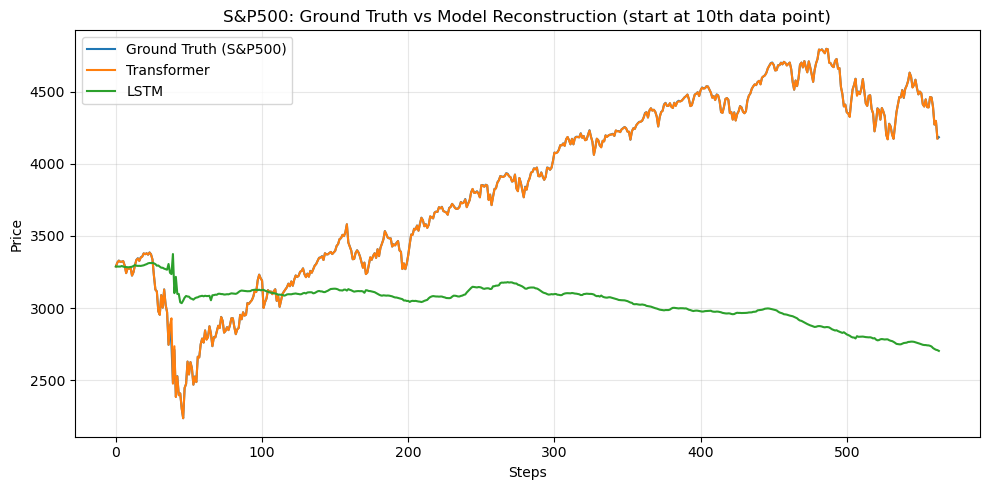

In [301]:
# Plot ground truth vs reconstructed trajectory
import matplotlib.pyplot as plt
import numpy as np

start_idx = N - 1
end_idx = start_idx + len(recon_prices) - 1

# Align ground truth slice
gt_slice = sp500_prices[start_idx:end_idx+1]
if len(gt_slice) != len(recon_prices):
    min_len = min(len(gt_slice), len(recon_prices))
    gt_slice = gt_slice[:min_len]
    recon_plot = recon_prices[:min_len]
else:
    recon_plot = recon_prices

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gt_slice, label='Ground Truth (S&P500)')
# ax.plot(recon_prices_mlp, label='MLP')
ax.plot(recon_prices_tf, label='Transformer')
ax.plot(recon_prices_lstm, label='LSTM')
# ax.plot(lala, label='TCN')
# ax.plot(lala_1, label='TCN_zero')
# ax.plot(recon_prices_tcn, label='TCN')
ax.set_title('S&P500: Ground Truth vs Model Reconstruction (start at 10th data point)')
ax.set_xlabel('Steps')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
